In [2]:
import torch
from torch import nn
import numpy as np
import torchaudio
import os
from numpy import sort
import numpy as np


%matplotlib inline
import matplotlib.pyplot as plt

seed = 42

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True


ERROR! Session/line number was not unique in database. History logging moved to new session 274


# Data Cleaning/Creation
## Prepare data to input into our model

In [3]:
def load_audio_data(data_directory, new_sample_rate=8000):
    classes = sort(list(filter(lambda x: x[0] != '.', os.listdir(data_directory))))
    print(classes)
    

    data = []
    labels = []
    for i, c in enumerate(classes):
        for f in os.listdir(data_directory + c):
            try:
                waveform, sample_rate = torchaudio.load(data_directory + c + '/' + f)
                transform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
                
                data.append(transform(waveform))
                labels.append(i)
            except:
                continue

    return data, labels, classes

In [4]:
data_directory = 'Data/genres_original/'
data, labels, classes = load_audio_data(data_directory)

['blues' 'classical' 'country' 'disco' 'hiphop' 'jazz' 'metal' 'pop'
 'reggae' 'rock']


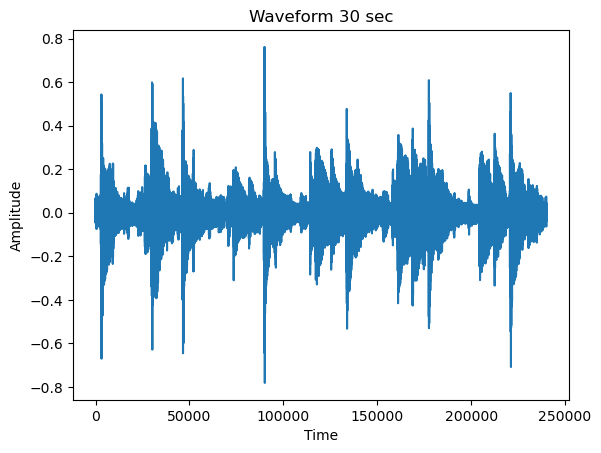

In [5]:
#print waveform 
w = data[0]
plt.figure()
plt.title('Waveform 30 sec')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.plot(w.t().numpy())
plt.show()

### Split data into train and test sets

In [6]:
# seperate data into training and testing so that there are equal labels in test set

#split data into training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed, stratify=labels)
# make sure every tensor is the same size by padding
max_length = max([x.shape[1] for x in X_train])
X_train = [torch.nn.functional.pad(x, (0, max_length - x.shape[1])) for x in X_train]
X_test = [torch.nn.functional.pad(x, (0, max_length - x.shape[1])) for x in X_test]

### Batch data

In [7]:
batch_size = 8
train_data = list(zip(X_train, y_train))
test_data = list(zip(X_test, y_test))
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Creating a Model and Trainging It


In [8]:
class AudioClassificationModel(nn.Module):
    def __init__(self, n_input, n_channel, n_output):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv1d(n_input, n_channel, kernel_size=80, stride=16),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.Conv1d(n_channel, n_channel, kernel_size=3, stride=1),
            nn.BatchNorm1d(n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.Conv1d(n_channel, 2*n_channel, kernel_size=3, stride=1),
            nn.BatchNorm1d(2*n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.Conv1d(2*n_channel, 2*n_channel, kernel_size=3, stride=1),
            nn.BatchNorm1d(2*n_channel),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=4, stride=4),

            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(2*n_channel, n_output)
        )


    def forward(self, x):
        return self.layers(x)


In [9]:
def train_audio_classification_model(model, train_loader, n_epochs, lr):
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(n_epochs):
        model.train()
        losses = []
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            y_pred = model(inputs)
           
            loss = criterion(y_pred, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
        average_loss = np.mean(losses)
        print(f'Epoch {epoch+1}/{n_epochs}, Average Loss: {average_loss}')
        

def test_audio_classification_model(model, test_loader, classes):
    model.eval()
    correct = 0
    total = 0
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            #make a list of predicted vs actual labels
            y_pred = model(inputs)
            _, predicted = torch.max(y_pred, 1)
            predictions.extend(predicted.numpy())
            actuals.extend(labels.numpy())
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {correct/total}')

    return correct / total, predictions, actuals
        

In [10]:
model = AudioClassificationModel(n_input=1, n_channel=64, n_output=len(classes))
print(model)

AudioClassificationModel(
  (layers): Sequential(
    (0): Conv1d(1, 64, kernel_size=(80,), stride=(16,))
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 128, kernel_size=(3,), stride=(1,))
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (12): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): MaxPool1d(kernel_size=4, stride=4, pa

In [19]:
train_audio_classification_model(model, train_loader, n_epochs=20, lr=0.01)

Epoch 1/20, Average Loss: 0.8157885348796845
Epoch 2/20, Average Loss: 0.7298835016787052
Epoch 3/20, Average Loss: 0.7394102459400892
Epoch 4/20, Average Loss: 0.6341254012286663
Epoch 5/20, Average Loss: 0.6084888233616949
Epoch 6/20, Average Loss: 0.5934031308814883
Epoch 7/20, Average Loss: 0.5573018392920495
Epoch 8/20, Average Loss: 0.5917208324745298
Epoch 9/20, Average Loss: 0.5321892304718494
Epoch 10/20, Average Loss: 0.50039889536798
Epoch 11/20, Average Loss: 0.5777571758627892
Epoch 12/20, Average Loss: 0.4808515023812652
Epoch 13/20, Average Loss: 0.48855751305818557
Epoch 14/20, Average Loss: 0.47076716605573893
Epoch 15/20, Average Loss: 0.5026409448496998
Epoch 16/20, Average Loss: 0.3724600680638105
Epoch 17/20, Average Loss: 0.47443748462945223
Epoch 18/20, Average Loss: 0.39613686095923184
Epoch 19/20, Average Loss: 0.44640033366158605
Epoch 20/20, Average Loss: 0.3458104718569666


In [23]:
#get current time to save model
import datetime
now = datetime.datetime.now()
name = 'Models/model' + now.strftime("%Y%m%d%H%M") + '.pt'
torch.save(model, name)

In [13]:
# model = torch.load('Models/model202404101934.pt')

Accuracy: 0.7


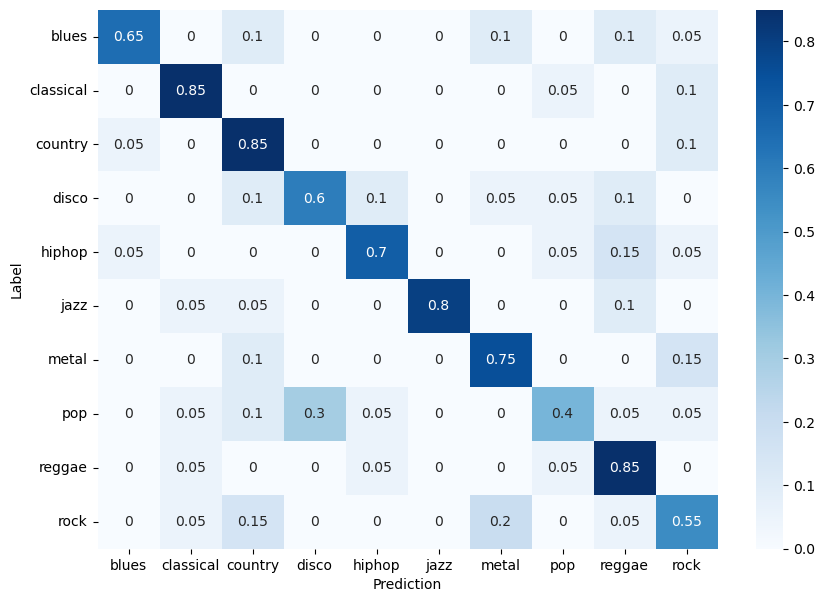

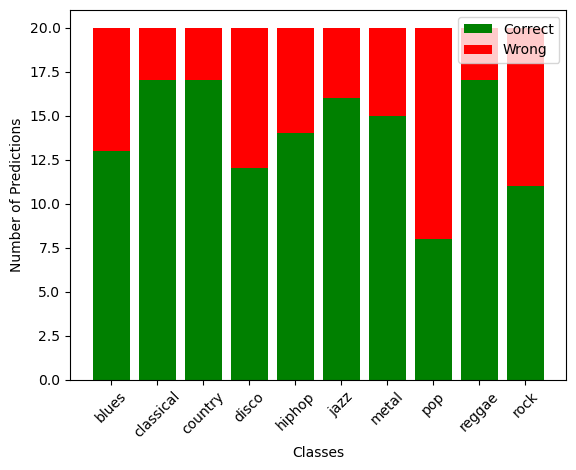

In [20]:
accuracy, predictions, actual = test_audio_classification_model(model, test_loader, classes)


def plot_confusion_matrix(y_true, y_pred, classes):
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import pandas as pd
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)
    df_cm = pd.DataFrame(cm, index=classes, columns=classes)
    plt.figure(figsize=(10,7))
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()
plot_confusion_matrix(actual, predictions, classes)

#plot bar graph real vs predicted
def plot_prediction_distribution(y_true, y_pred, classes):
    for(i, c) in enumerate(classes):
        correct = 0
        wrong = 0
        for j in range(len(y_true)):
            if y_true[j] == i:
                if y_pred[j] == i:
                    correct += 1
                else:
                    wrong += 1
        plt.bar(c, correct, color='g')
        plt.bar(c, wrong, bottom=correct, color='r')
    plt.legend(['Correct', 'Wrong'])
    plt.xlabel('Classes')
    plt.ylabel('Number of Predictions')
    plt.xticks(rotation=45)
    plt.show()
            

plot_prediction_distribution(actual, predictions, classes)


In [15]:
# def split_audio_clips(data, labels, clip_duration):
#     split_data = []
#     split_labels = []

#     # for i, (waveform, sample_rate) in enumerate(data):
#     #     # Calculate the number of samples in each clip
#     #     clip_samples = int(sample_rate * clip_duration)

#     #     # Split the waveform into clips
#     #     for start in range(0, waveform.shape[1], clip_samples):
#     #         end = start + clip_samples
#     #         if end <= waveform.shape[1]:
#     #             clip = waveform[:, start:end]
#     #             split_data.append(clip)
#     #             split_labels.append(labels[i])

#     # return split_data, split_labels
#     for i, waveform in enumerate(data):
#         # Calculate the number of samples in each clip
#         clip_samples = int(waveform.shape[1] / clip_duration)

#         # Split the waveform into clips
#         for start in range(0, waveform.shape[1], clip_samples):
#             end = start + clip_samples
#             if end <= waveform.shape[1]:
#                 clip = waveform[:, start:end]
#                 split_data.append(clip)
#                 split_labels.append(labels[i])
#     return split_data, split_labels